# The Lensing Posterior

At its heart, CMBLensing.jl is centered around the "CMB lensing posterior". We work with both the "**joint posterior**", which is joint over all variables,

$$ \mathcal{P}(f,\phi,\theta\,|\,d), $$

or the "**marginal posterior**", 

$$ \mathcal{P}(\phi,\theta\,|\,d) \equiv \int \! \mathcal{D}f \; \mathcal{P}(f,\phi,\theta\,|\,d), $$

which is simply the joint posterior analytically marginalized over $f$. Here,

* $f$ are the CMB fields (T/Q/U),
* $\phi$ is the lensing potential,
* $\theta$ are any cosmological parameters,
* $d$ is the data.



The default data model which is assumed, which is generally flexible enough to handle real experiments (but can be customized), is:

$$ d =  \mathbb{A} \, \mathbb{L}(\phi) \, f + n, $$

where

$$ \mathbb{A} = \mathbb{P} \, \mathbb{M} \, \mathbb{B} $$

and 

* $\mathbb{L}(\phi)$ is the lensing operation
* $\mathbb{B}$ is an instrumental transfer function or "beam"
* $\mathbb{M}$ is a user-chosen mask
* $\mathbb{P}$ is a pixelization operation which allows one to estimate $f$ on a higher resolution than the data
* $n$ is the instrumental noise. 


Given this model, the joint posterior (up to an unimportant normalization constant) is:

$$ 
-2\ln\mathcal{P}(f,\phi,\theta\,|\,d) = \frac{\big(d - \mathbb{A} \, \mathbb{L}(\phi) \, f\big)^2}{\mathbb{C}_n}
+ \frac{f^2}{\mathbb{C}_f(\theta)} + \frac{\phi^2}{C_\phi(\theta)} + \log\det \mathbb{C}_f(\theta) + \log\det C_\phi(\theta),
$$

and the marginal posterior is:

$$ 
-2\ln\mathcal{P}(\phi,\theta\,|\,d) = \frac{d^2}{\mathbb{\Sigma}_d(\phi,\theta)} + \frac{\phi^2}{C_\phi(\theta)} + \log\det \mathbb{\Sigma}_d(\phi,\theta) + \log\det C_\phi(\theta),
$$

where

$$
\Sigma_d = \mathbb{A} \, \mathbb{L}(\phi) \, \mathbb{C}_f(\theta) \, \mathbb{L}(\phi)^\dagger \mathbb{A}^\dagger + \mathbb{C}_n
$$

and

* $\mathbb{C}_n$ is the noise covariance
* $\mathbb{C}_f$ is the CMB covariance (i.e. the CMB T, E, and B $C_\ell$'s)
* $\mathbb{C}_\phi$ is the lensing potential covariance (i.e. $C_\ell^{\phi\phi}$)

and we have used the slighly sloppy notation $x^2/\mathbb{C}$ to mean $x^\dagger \mathbb{C}^{-1} x$.

## Posterior basics

In [1]:
using CMBLensing, PyPlot

CMBLensing uses the function `lnP` to compute the log of the joint posterior probability. 

To evaluate this posterior, we need the arguments of the probability distribution, $f$, $\phi$, and $\theta$. We also need the data $d$ and host of other operators and covariances which enter the expressions above, which CMBLensing stores in a `DataSet` object.

First lets load up some simulated data. The function `load_sim_dataset` handles constructing a `DataSet` and is the recommended way to create the various fields and covariances needed. In this case, let's use 1$\mu$K-arcmin noise and a border mask:

In [2]:
@unpack f, f̃, ϕ, ds, L = load_sim_dataset(
    θpix      = 2,
    Nside     = 256,
    T         = Float64,
    pol       = :P,
    μKarcminT = 1,
    L         = LenseFlow{RK4Solver{10}},
    seed      = 0,
    pixel_mask_kwargs = (edge_padding_deg=1, apodization_deg=0, num_ptsrcs=0),
    bandpass_mask     = LowPass(5000)
);

The `DataSet` object, by convention called `ds`, stores all the aforementioned quantities:

In [3]:
fieldnames(typeof(ds))

(:d, :Cϕ, :Cf, :Cf̃, :Cn, :Cn̂, :M, :M̂, :B, :B̂, :D, :G, :P, :L)

For example, the data is:

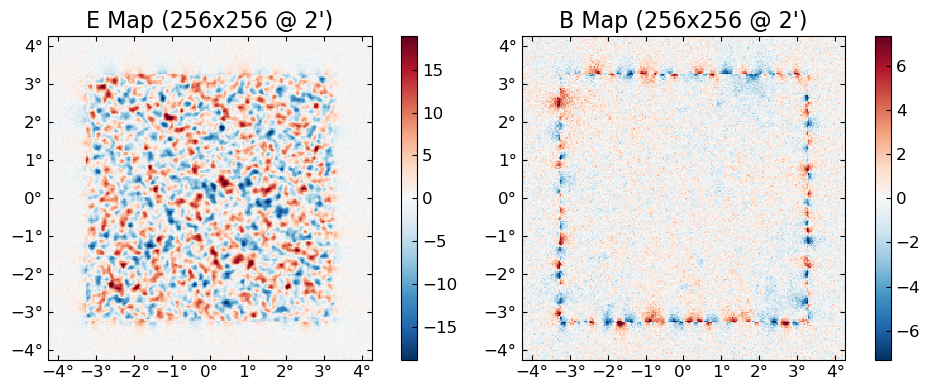

In [4]:
plot(ds.d);

Or the diagonal of the $\mathbb{C}_f$ operator:

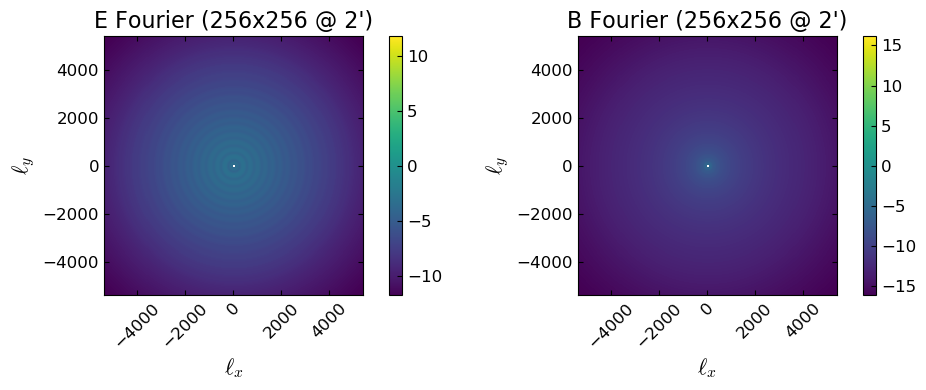

In [5]:
plot(diag(ds.Cf), which=[:El :Bl])

We can now evaluate the posterior, for example at the true $f$ and $\phi$:

In [6]:
-2*lnP(0, f, ϕ, ds)

328093.93767088983

The first argument, in this case `0`, indicates the parameterization. We can compute the posterior given a couple of different parametrizations,

* The unlensed parametrization, $\mathcal{P}(f,\phi,\theta\,|\,d)$
* The lensed parametrization, $\mathcal{P}(\tilde f,\phi,\theta\,|\,d)$ where $\tilde f$ are the _lensed_ CMB fields.
* The mixed parametrization, $\mathcal{P}(f^\prime, \phi^\prime, \theta \,|\, d)$ where $f^\prime$ and $\phi^\prime$ are the _mixed_ CMB fields and lensing potential (this is a parametrization which attemps to decorrelate the posterior as much as possible; you may want to read [our paper](https://arxiv.org/TBD) which describes this in more detail).

For the unlensed and lensed parametrizations, pass `0` and `1` as the first argument  (these refer to auxillary "time" variable in the LenseFlow expansion, $f(x+t\nabla\phi)$; at $t=0$ we have the unlensed field, and at $t=1$ we have the lensed field). If we use the lensed parametrization, then the $f$ argument to the function is expected to be the lensed field. The mixed parametrization can be specified by passing `:mix` as the first argment, in which case the $f$ argument is expected to be the mixed field.

For example, the following is the same point in parameter space that we evaluated above, just in a different parametrization (any differences to the above value are numerical):

In [7]:
-2*lnP(1, L(ϕ)*f, ϕ, ds)

328098.0587218067

We expect minus twice the posterior evaluated at the truth to be distributed like a $\chi^2$ distribution where the degrees of freedom equals the number of pixels in $d$, $f$, and $\phi$ (i.e. in each of the three Gaussian terms in the posterior). Since these maps are 256x256 and $d$ and $f$ have both Q and U maps, this is:

In [8]:
(2+2+1)*256^2

327680

which the previous result is within a few sigma of.

Above, we didn't specify any cosmological parameters, $\theta$. Because of that, they were fixed at their fiducial values (i.e. the fiducial values which generated the simulated data in the call to `load_sim_dataset` earlier). Current only two parameters can be varied, $r$ (tensor-to-scalar ratio), and $A_\phi$ (the amplitude of $C_\ell^{\phi \phi}$). They can be specified as follows, with non-specified parameters left at their fiducial:

In [9]:
-2*lnP(0, f, ϕ, (Aϕ=1.1,), ds)

328369.64106579835

You can see the slight change compared to what we got above. We can even compute a whole slice through the posterior along $A_\phi$:

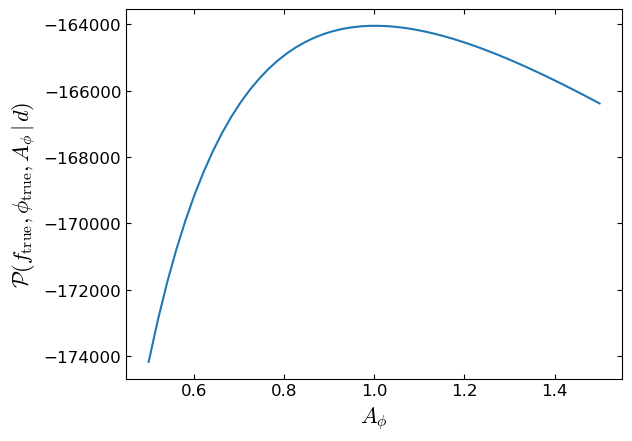

In [10]:
Aϕs = range(0.5,1.5,length=50)
plot(Aϕs, [lnP(0, f, ϕ, (Aϕ=Aϕ,), ds) for Aϕ in Aϕs])
xlabel(raw"$A_\phi$")
ylabel(raw"$\mathcal{P}(f_{\rm true}, \phi_{\rm true}, A_\phi\,|\,d)$");

## Wiener filtering

If we fix $\phi$ and $\theta$ then maximize the joint posterior, $\mathcal{P}(f,\phi,\theta\,|\,d)$, over $f$, we get

$$
\hat f_{\rm wf} = \big[ \mathbb{C}_f(\theta)^{-1} + \mathbb{L}(\phi)^\dagger \mathbb{A}^\dagger\mathbb{C}_n^{-1}\mathbb{A} \, \mathbb{L}(\phi) \big]^{-1} \mathbb{L}(\phi)^\dagger \mathbb{A}^\dagger\mathbb{C}_n^{-1}d
$$

This is simply the Wiener filter of the data given a signal covariance which includes correlations induced by $\phi$, and we can compute it by inverting the operator in brackets above with e.g. conjugate gradient. 

In CMBLensing.jl, the `argmaxf_lnP` function performs this task. Its arguments are similar to `lnP`,

In [11]:
f_wf = argmaxf_lnP(ϕ, (Aϕ=1,), ds, tol=1e-1, progress=true);

Conjugate Gradient: 100%|███████████████████████████████| Time: 0:00:21


Wiener filtering effectively delenses the data by a given $\phi$. Here we are Wiener filtering at the true $\phi$, so this is perfect delensing. Note below the large amount of B mode power in the data, as well as the aliasing near the border mask, and how this is removed in the Wiener filtered B, which visually is tracing the true B map up to the level of the noise.

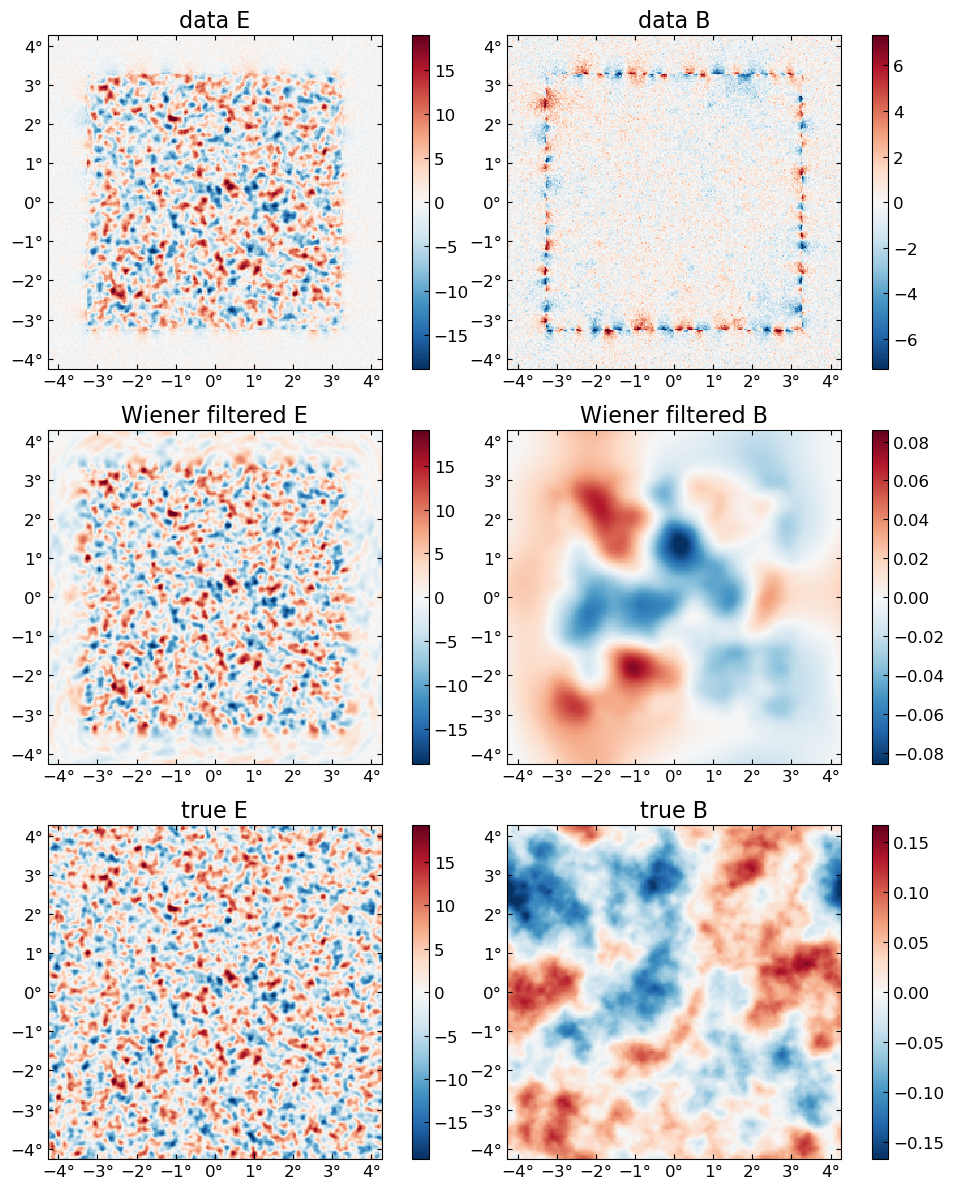

In [12]:
plot([ds.d, f_wf, f], title=["data ", "Wiener filtered ", "true "] .* ["E" "B"]);

## Posterior gradients

Fundamental to maximization and sampling algorithms in high dimensions are gradients of the posterior. CMBLensing.jl uses the interface provided by the automatic differentiation library [Zygote](https://github.com/FluxML/Zygote.jl/) to compute these gradients.

In [13]:
using Zygote

Zygote provides the `gradient` function, which takes a function for which to evaluate the gradient as the first argument, and the value at which to evaluate the gradient as the second argument. For example:

In [14]:
gradient(x->3x^2+2x, 1)

(8,)

Gradients of the CMB lensing posterior work in exactly the same way. For example, to take the gradient with respect to $\phi$ in the lensed parametrization, where we fix $f$ to the Wiener filter computed above and evaluate the gradient at $\phi=0$, we can do:

In [15]:
gϕ = gradient(ϕ -> lnP(1,f_wf,ϕ,ds), 0ϕ)[1];

Here's what this gradient looks like multiplied by $\mathbb{C}_\phi$. This is actually the first gradient step in the iterative joint maximum a posteriori estimation. The feature you see below is the mean-field in this estimate due to the mask:

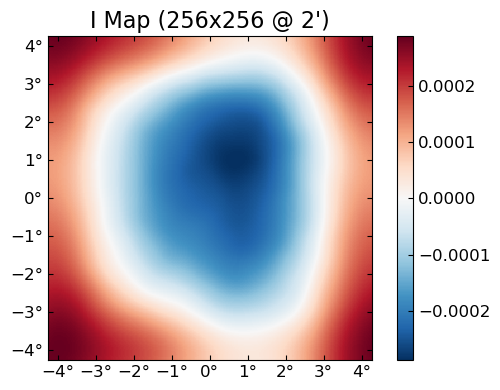

In [16]:
plot(ds.Cϕ*gϕ)

You are free to manipulate the fields inside of the function whose gradient is being taken, and Zygote will automatically propagate the chain rule for you:

In [17]:
gradient(ϕ -> -2lnP(1,f_wf,3ϕ,ds), 0ϕ)[1] ≈ -6 * gradient(ϕ -> lnP(1,f_wf,ϕ,ds), 0ϕ)[1]

true

Currently Zygote is working with many (but not all) operations that you can do to fields. If you run into things which Zygote is not able to differentiate successfully (generally you'll get some error), please feel free to file an [Issue](https://github.com/marius311/CMBLensing.jl/issues) with CMBLensing.jl.

Automatic differentiation is not yet working with respect to cosmological parameters, $\theta$, but is planned to be added.

## Marginal posterior

_work in progress_